### Part-2 NLP

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Loading the Data

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Reading the CSV file into a DataFrame for training data
train_df = pd.read_csv('/content/drive/MyDrive/jigsaw-toxic-comment-classification-challenge/train.csv.zip')

# Calculating the test size to ensure that the validation is exactly 5% of the training set
test_size = 0.05 / 0.95

# Splitting the train DataFrame into train and validation sets
train_data, validation_data = train_test_split(train_df, test_size=test_size, random_state=42)

# Printing the shape of the datasets to confirm the sizes
print(f"Training Set: {train_data.shape}")
print(f"Validation Set: {validation_data.shape}")

# Reading the test data and labels into DataFrames
test_df = pd.read_csv('/content/drive/MyDrive/jigsaw-toxic-comment-classification-challenge/test.csv.zip')
test_labels_df = pd.read_csv('/content/drive/MyDrive/jigsaw-toxic-comment-classification-challenge/test_labels.csv.zip')

# Merging the DataFrames on the 'id' column
test_data = pd.merge(test_df, test_labels_df, on='id')

# Filtering out the entries where any label is '-1'
test_data = test_data[test_data.toxic >= 0]

# Printing the shape of the merged DataFrame to confirm
print(f"Test Set: {test_data.shape}")

Training Set: (151172, 8)
Validation Set: (8399, 8)
Test Set: (63978, 8)


In [ ]:
train_df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   id             159571 non-null  object
 1   comment_text   159571 non-null  object
 2   toxic          159571 non-null  int64 
 3   severe_toxic   159571 non-null  int64 
 4   obscene        159571 non-null  int64 
 5   threat         159571 non-null  int64 
 6   insult         159571 non-null  int64 
 7   identity_hate  159571 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 9.7+ MB


In [ ]:
train_df.describe()

,toxic,severe_toxic,obscene,threat,insult,identity_hate
count,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000
mean,0.095844,0.009996,0.052948,0.002996,0.049364,0.008805
std,0.294379,0.099477,0.223931,0.054650,0.216627,0.093420
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Exploratory Data Analysis

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import string
from nltk.corpus import stopwords
from collections import Counter
import torchtext
from torchtext.data.utils import get_tokenizer
import random
import torch
import re
import nltk
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, precision_recall_fscore_support
import torch.nn as nn
import torch.optim as optim
from transformers import BertTokenizer

#### Comment Length

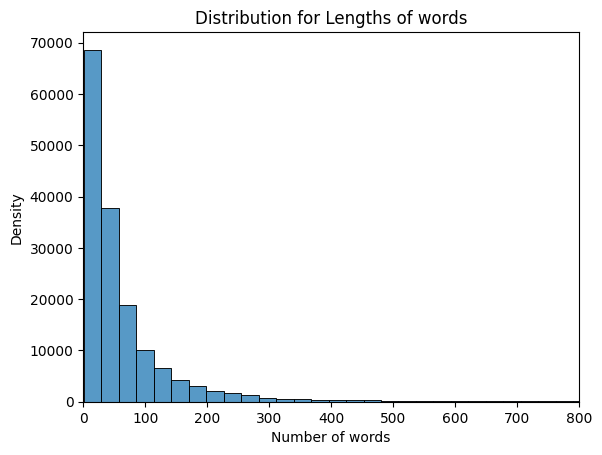

In [ ]:
comment_length = train_df['comment_text'].str.split().apply(len)
sns.histplot(comment_length,bins=50,)
plt.title("Distribution for Lengths of words")
plt.xlabel("Number of words")
plt.ylabel("Density")
plt.xlim(0, 800)
plt.show()

In [ ]:
train_df.isnull().sum()

id               0
comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
dtype: int64

### Check Unique Values

In [ ]:
train_df.nunique()

id               159571
comment_text     159571
toxic                 2
severe_toxic          2
obscene               2
threat                2
insult                2
identity_hate         2
dtype: int64

### Count per Class

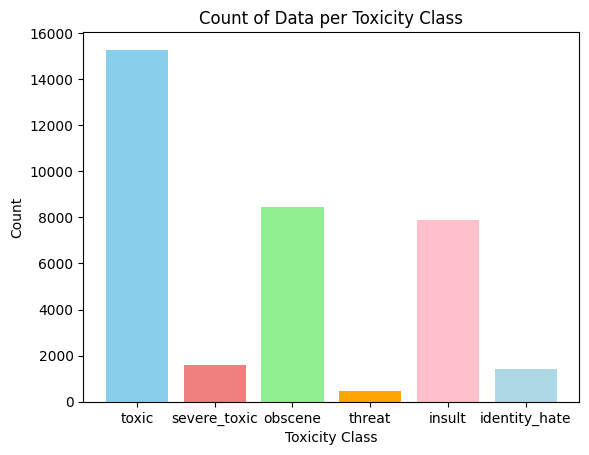

In [ ]:
label_counts = train_df.iloc[:, 2:].sum()

colors = ['skyblue', 'lightcoral', 'lightgreen', 'orange', 'pink', 'lightblue']

positions = range(len(label_counts))
labels = label_counts.index

plt.bar(positions, label_counts, color=colors)
plt.xticks(positions, labels, rotation=0)
plt.xlabel('Toxicity Class')
plt.ylabel('Count')
plt.title('Count of Data per Toxicity Class')
plt.show()

### Visualize Word counts

In [ ]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

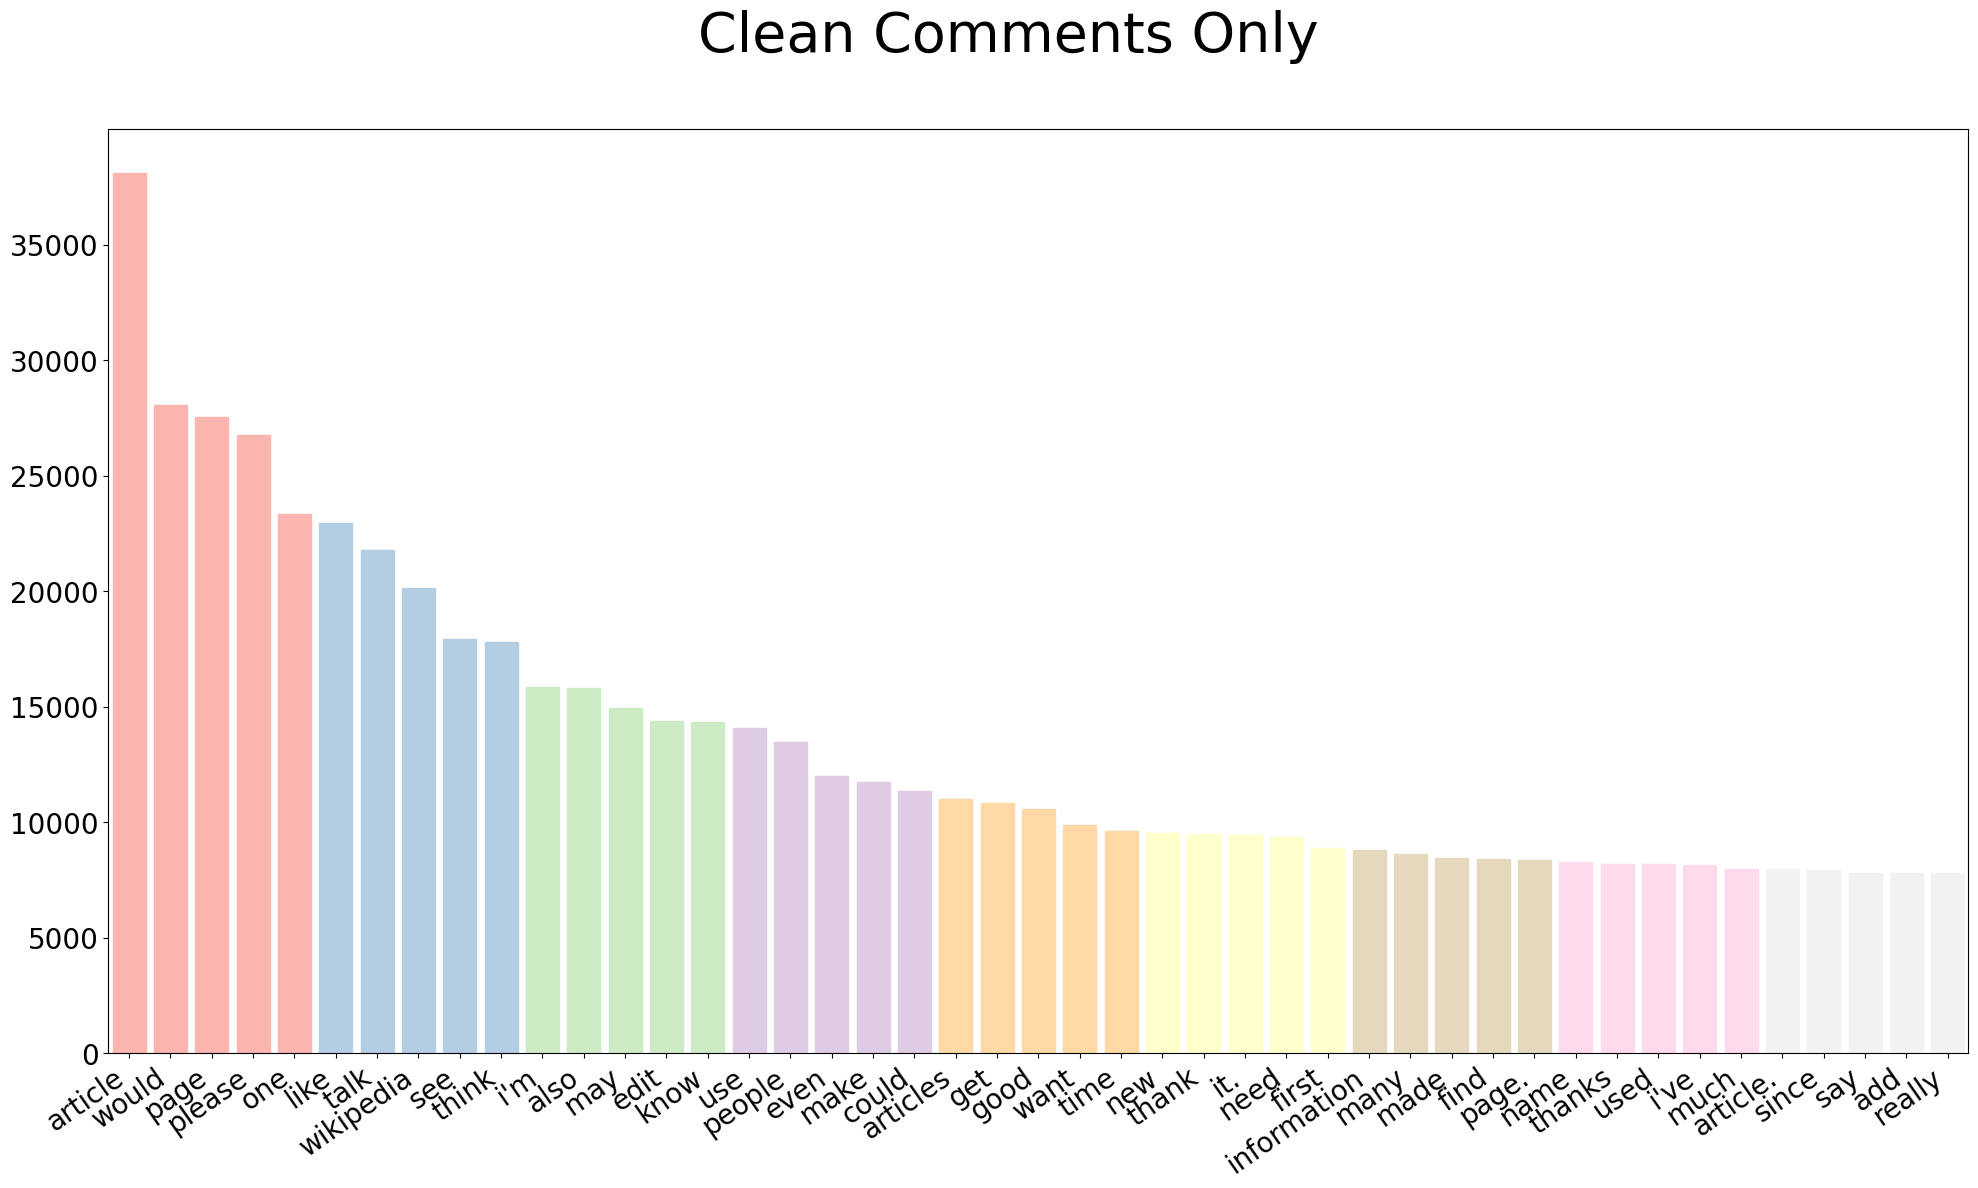

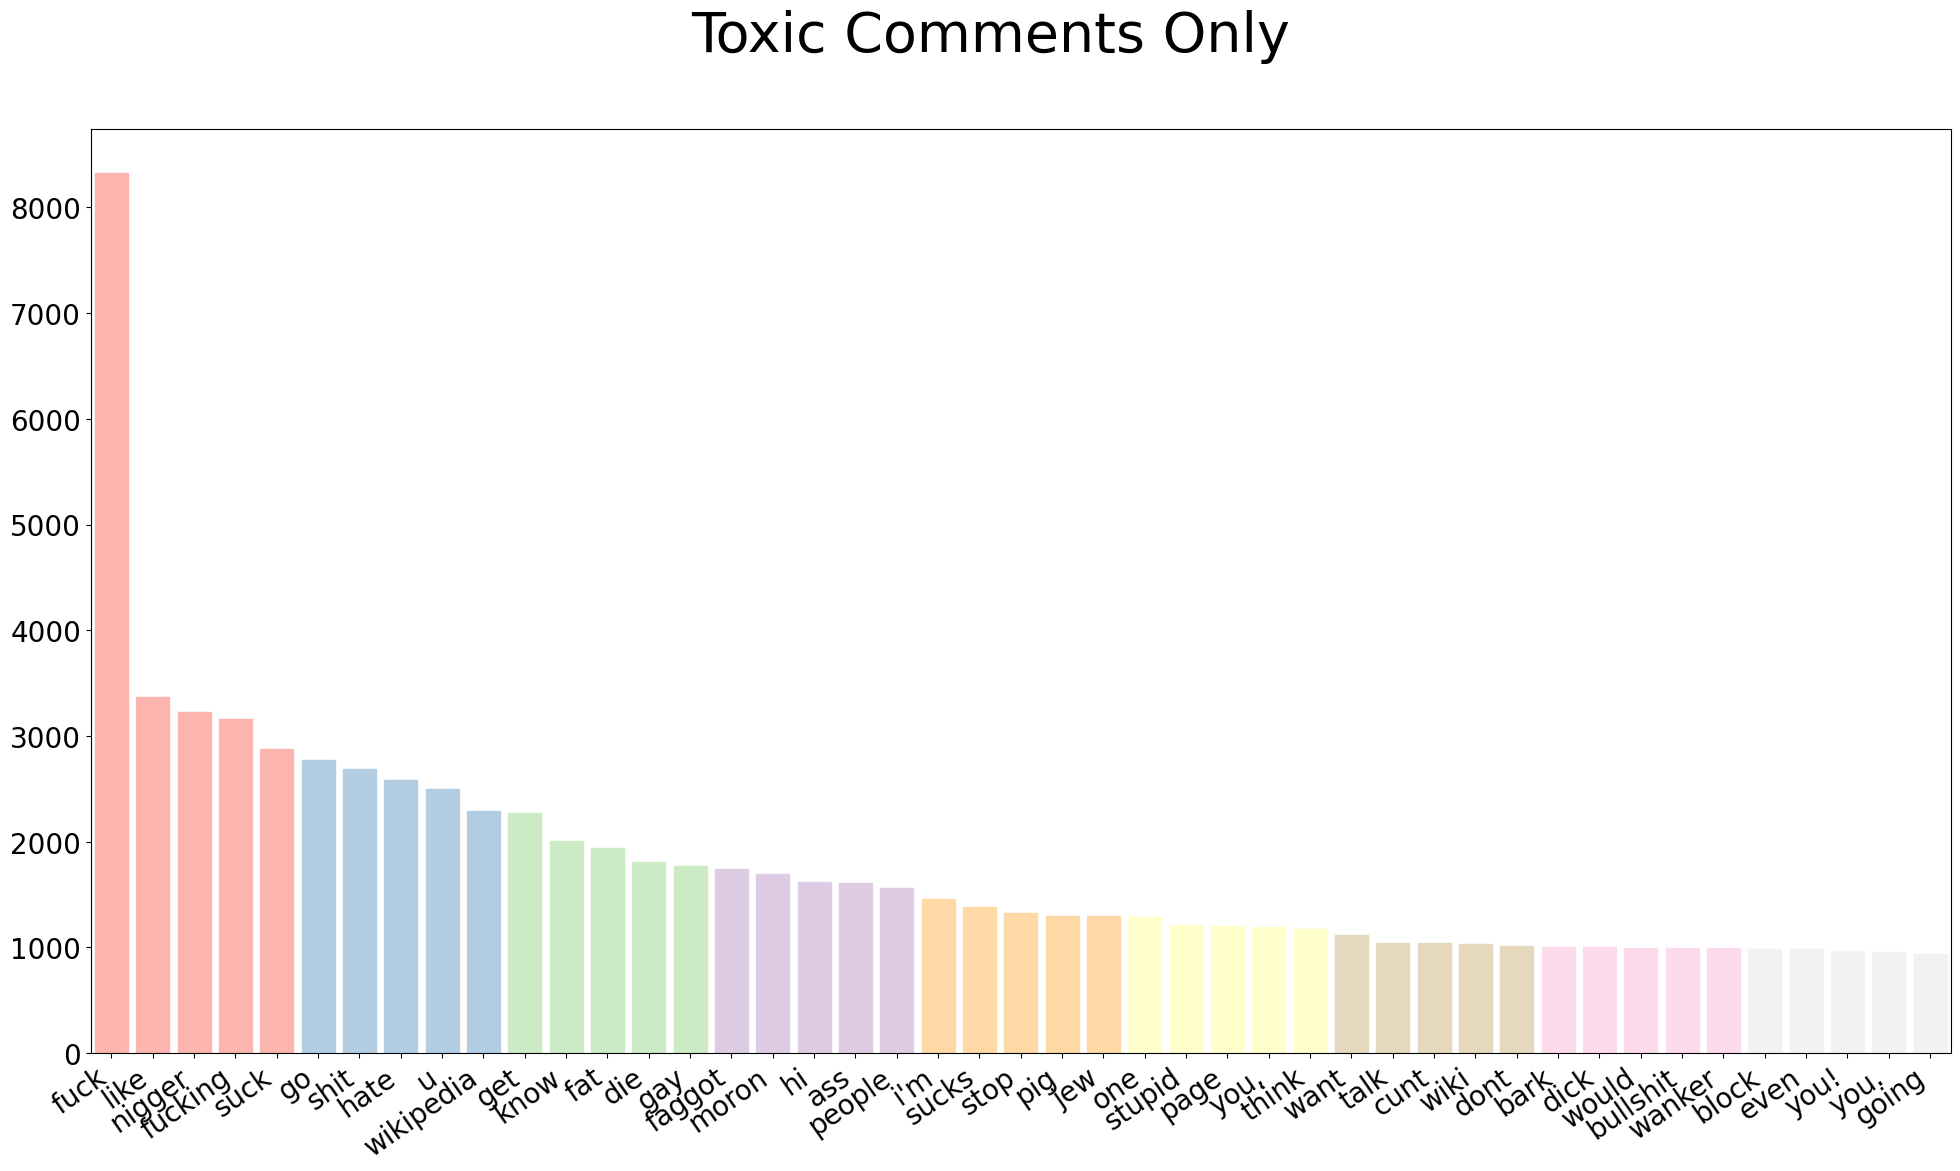

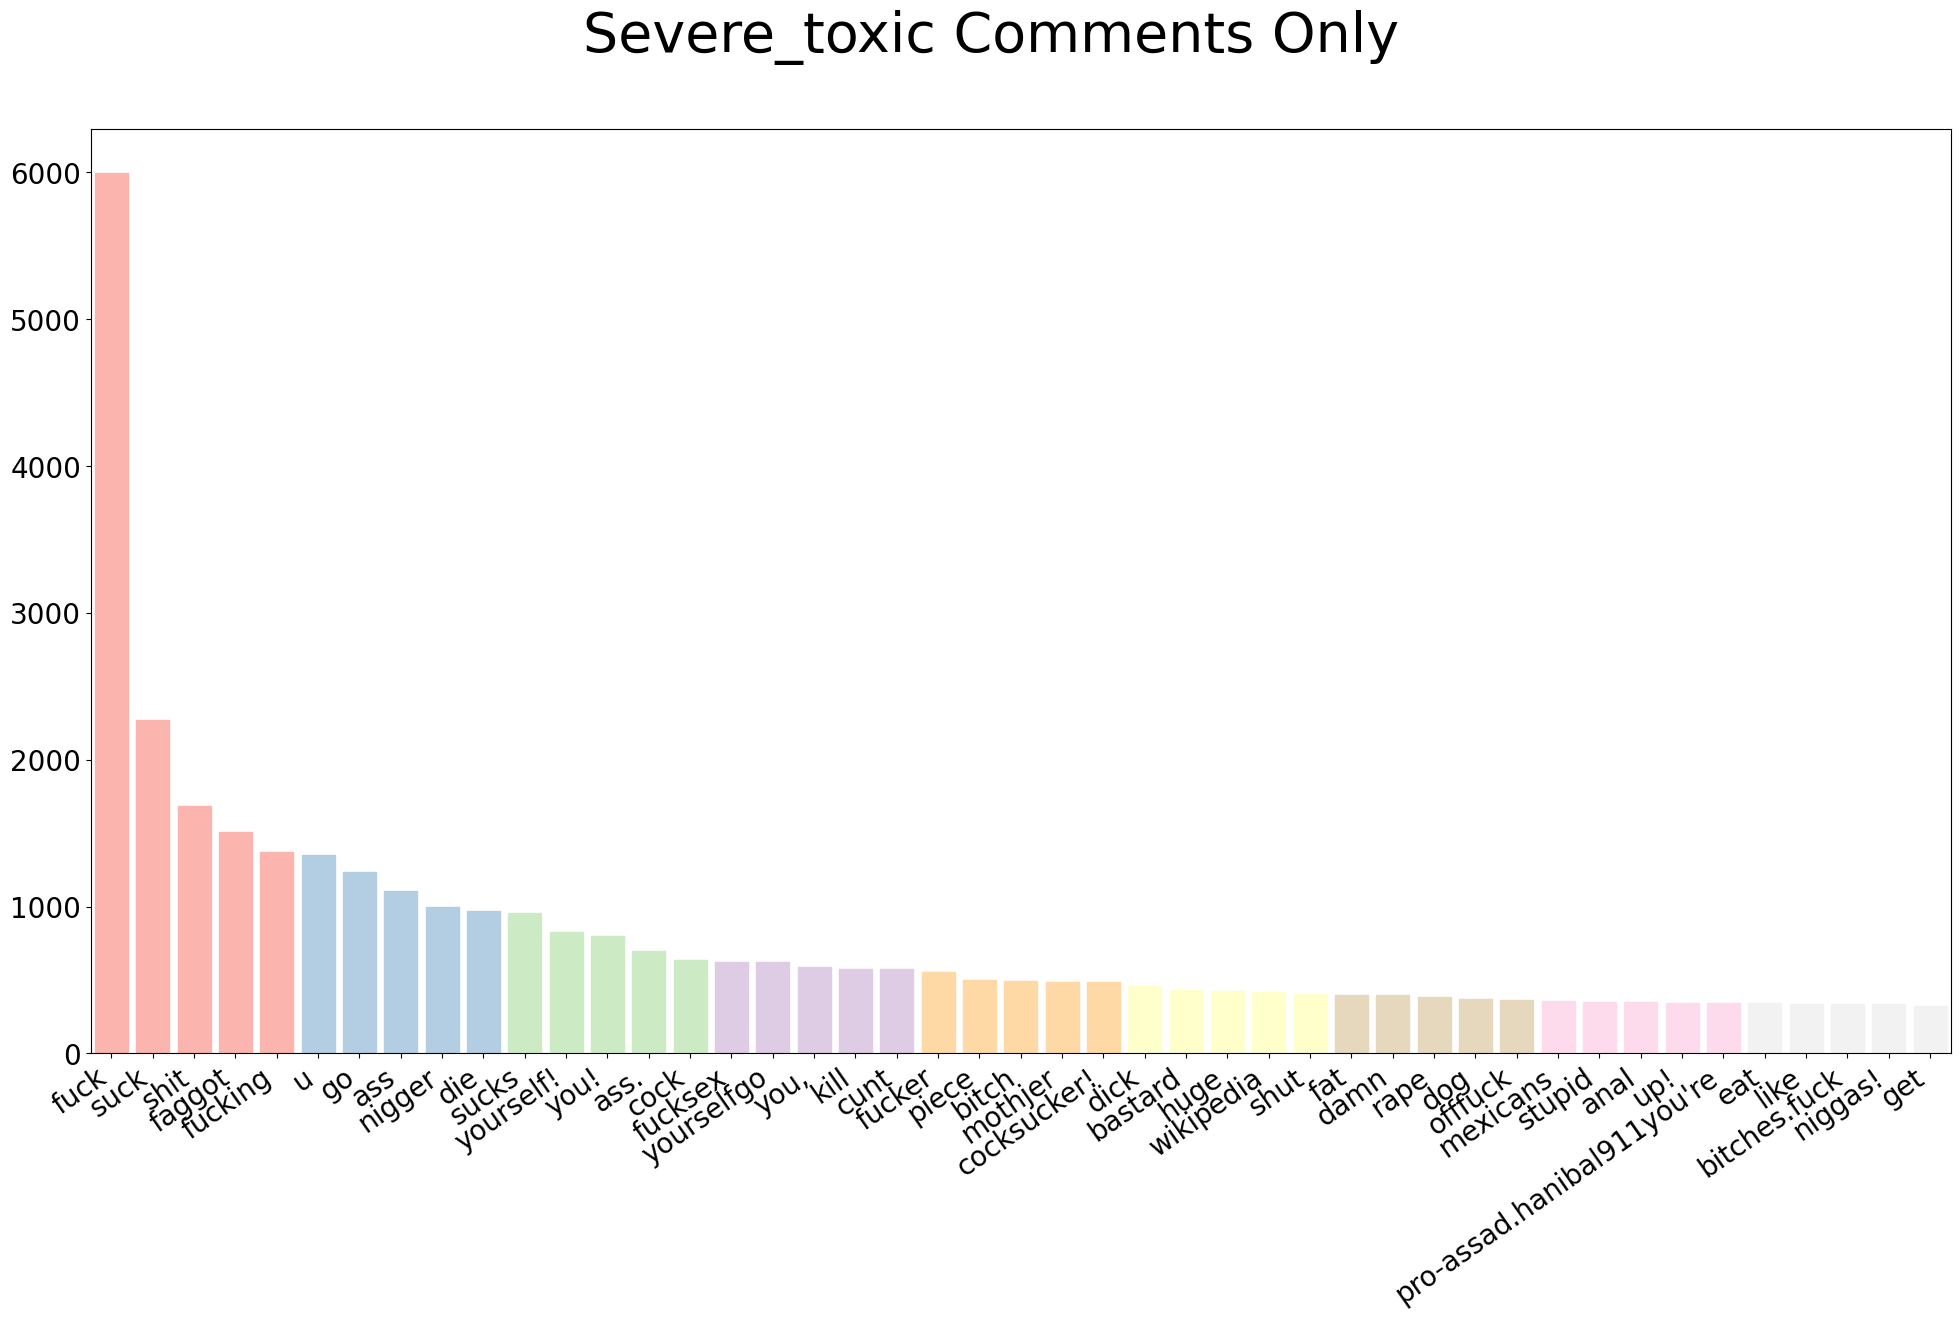

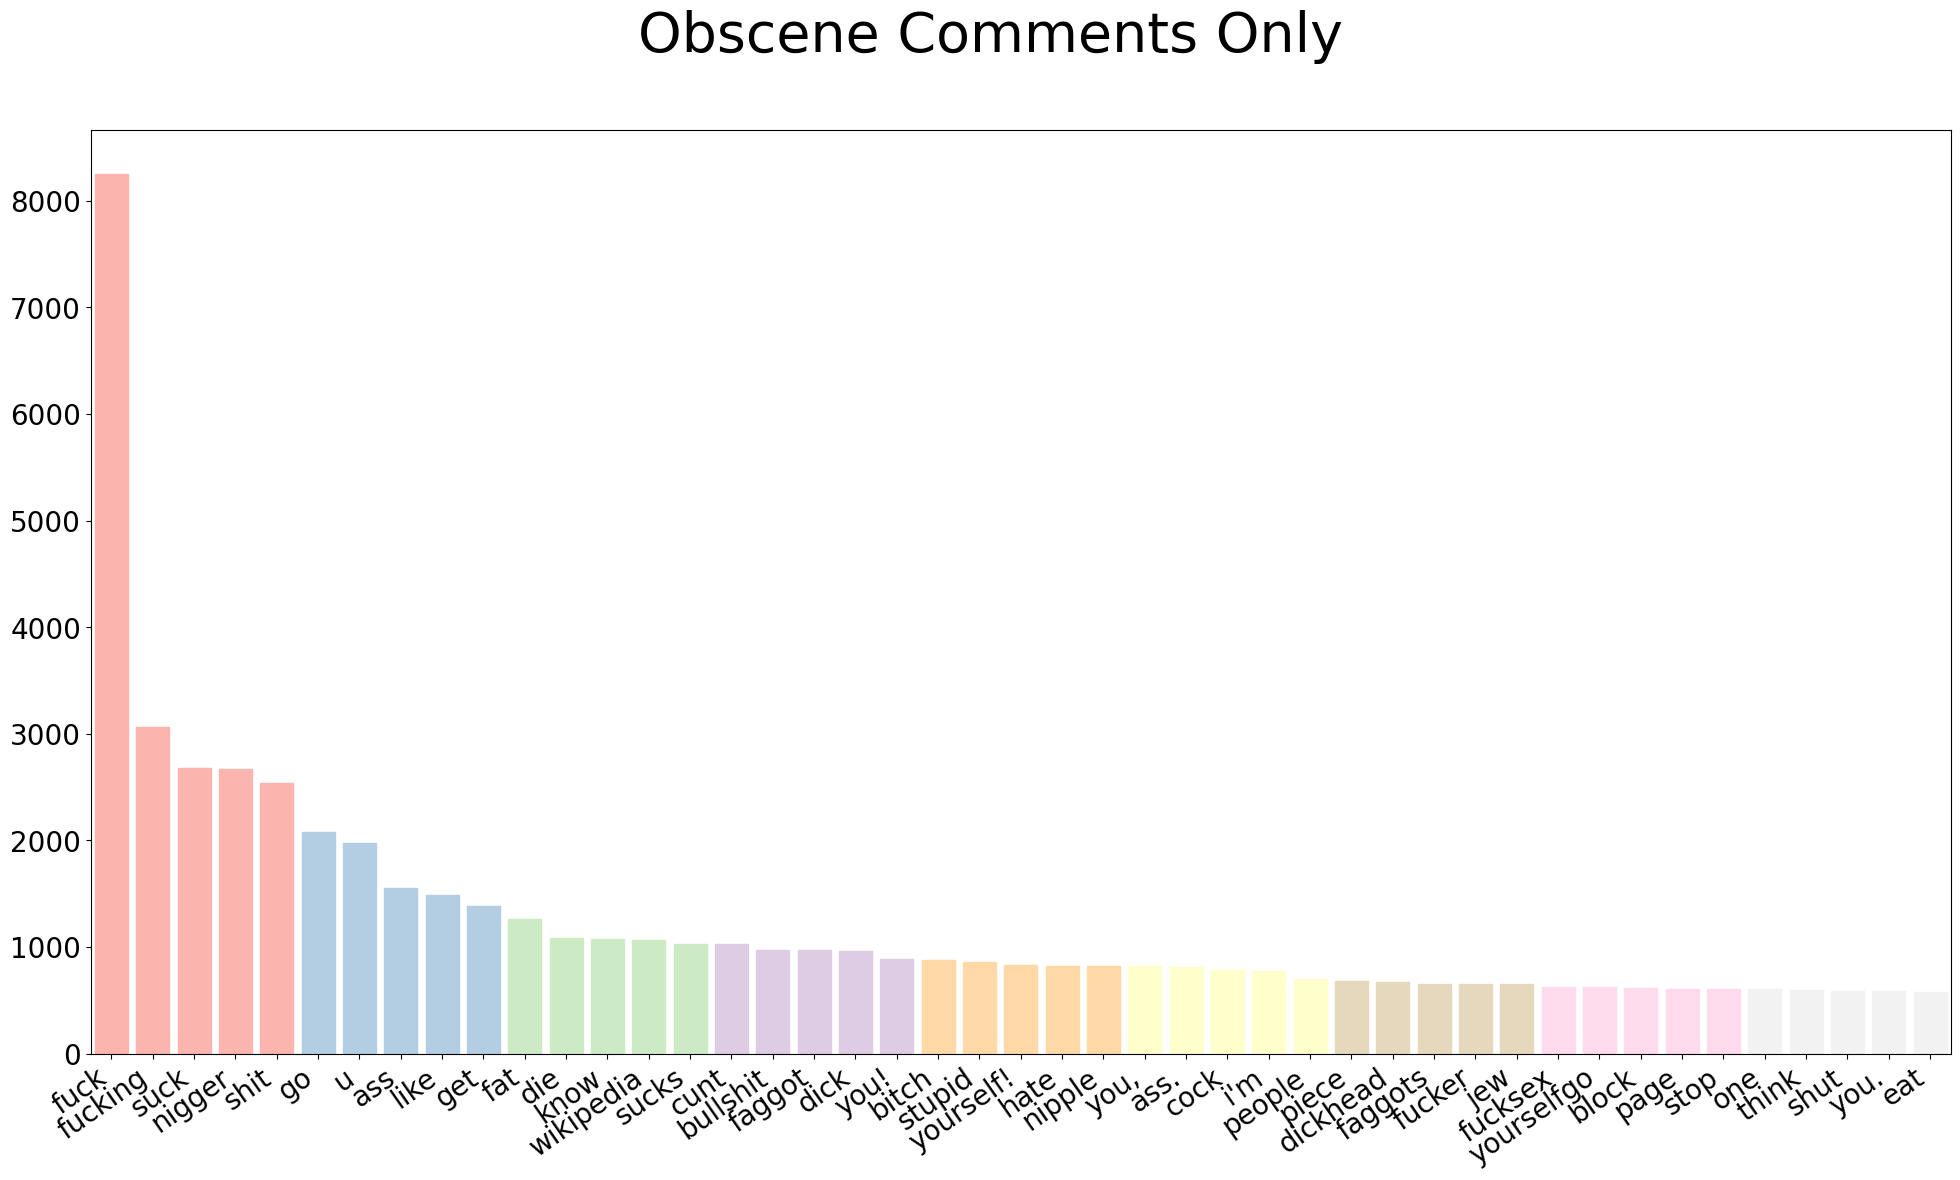

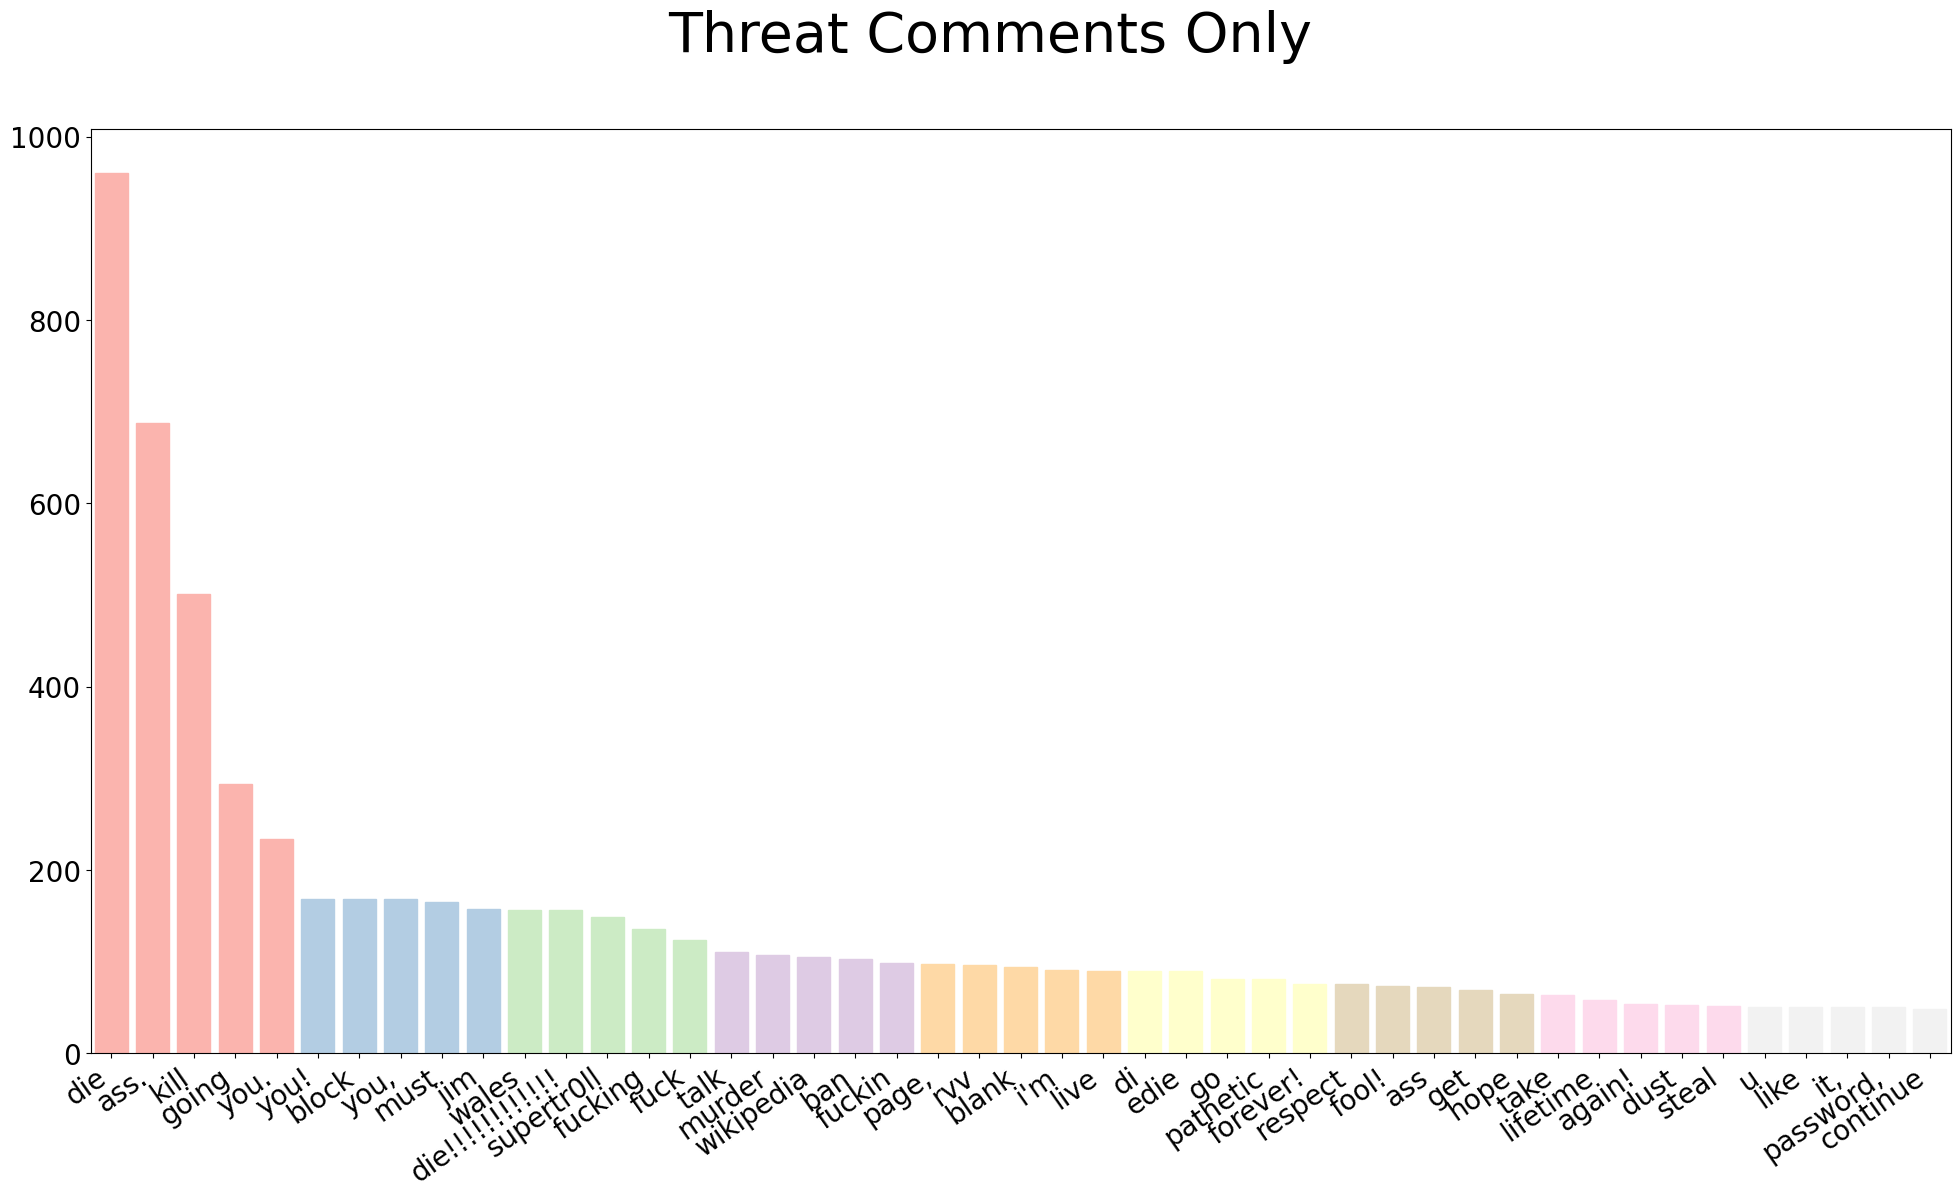

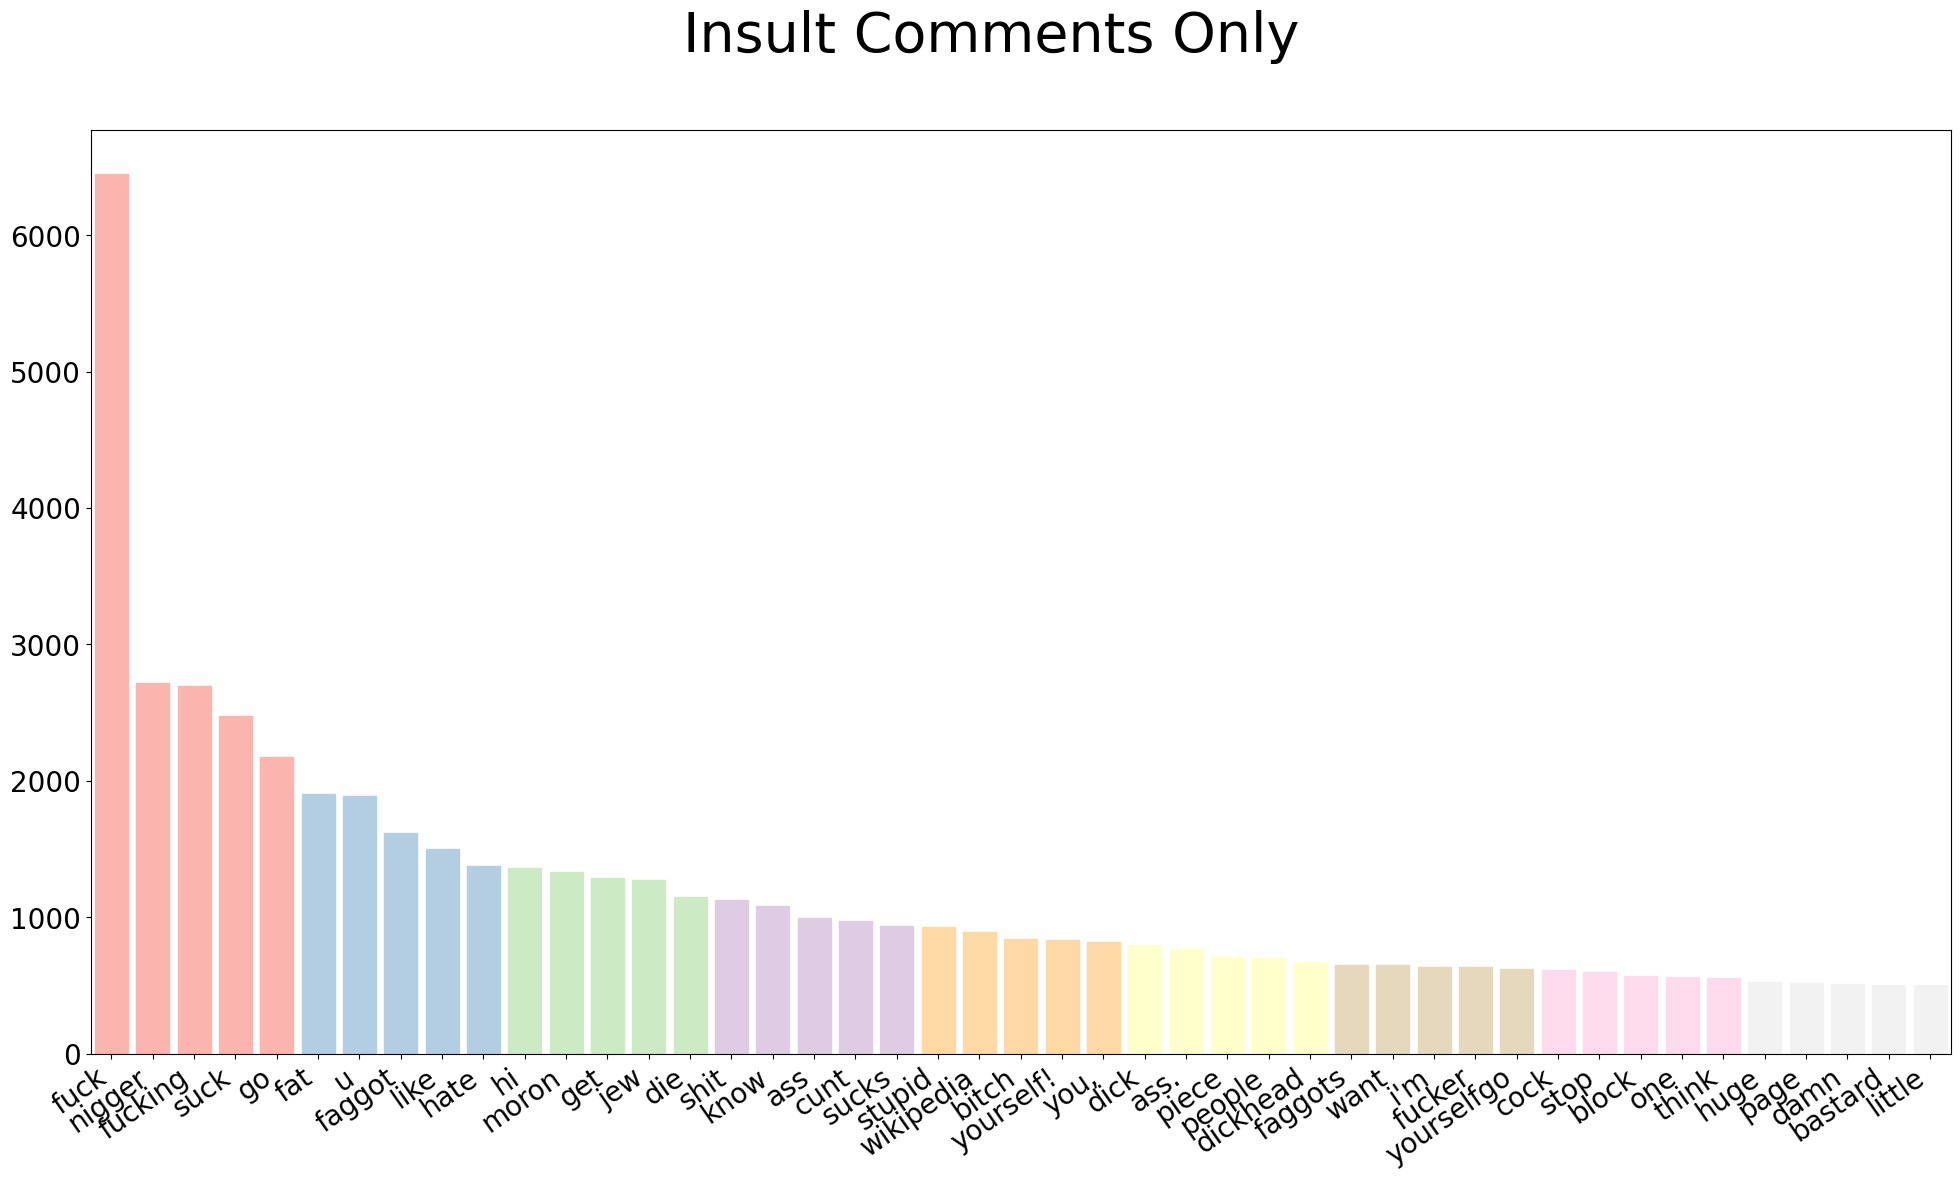

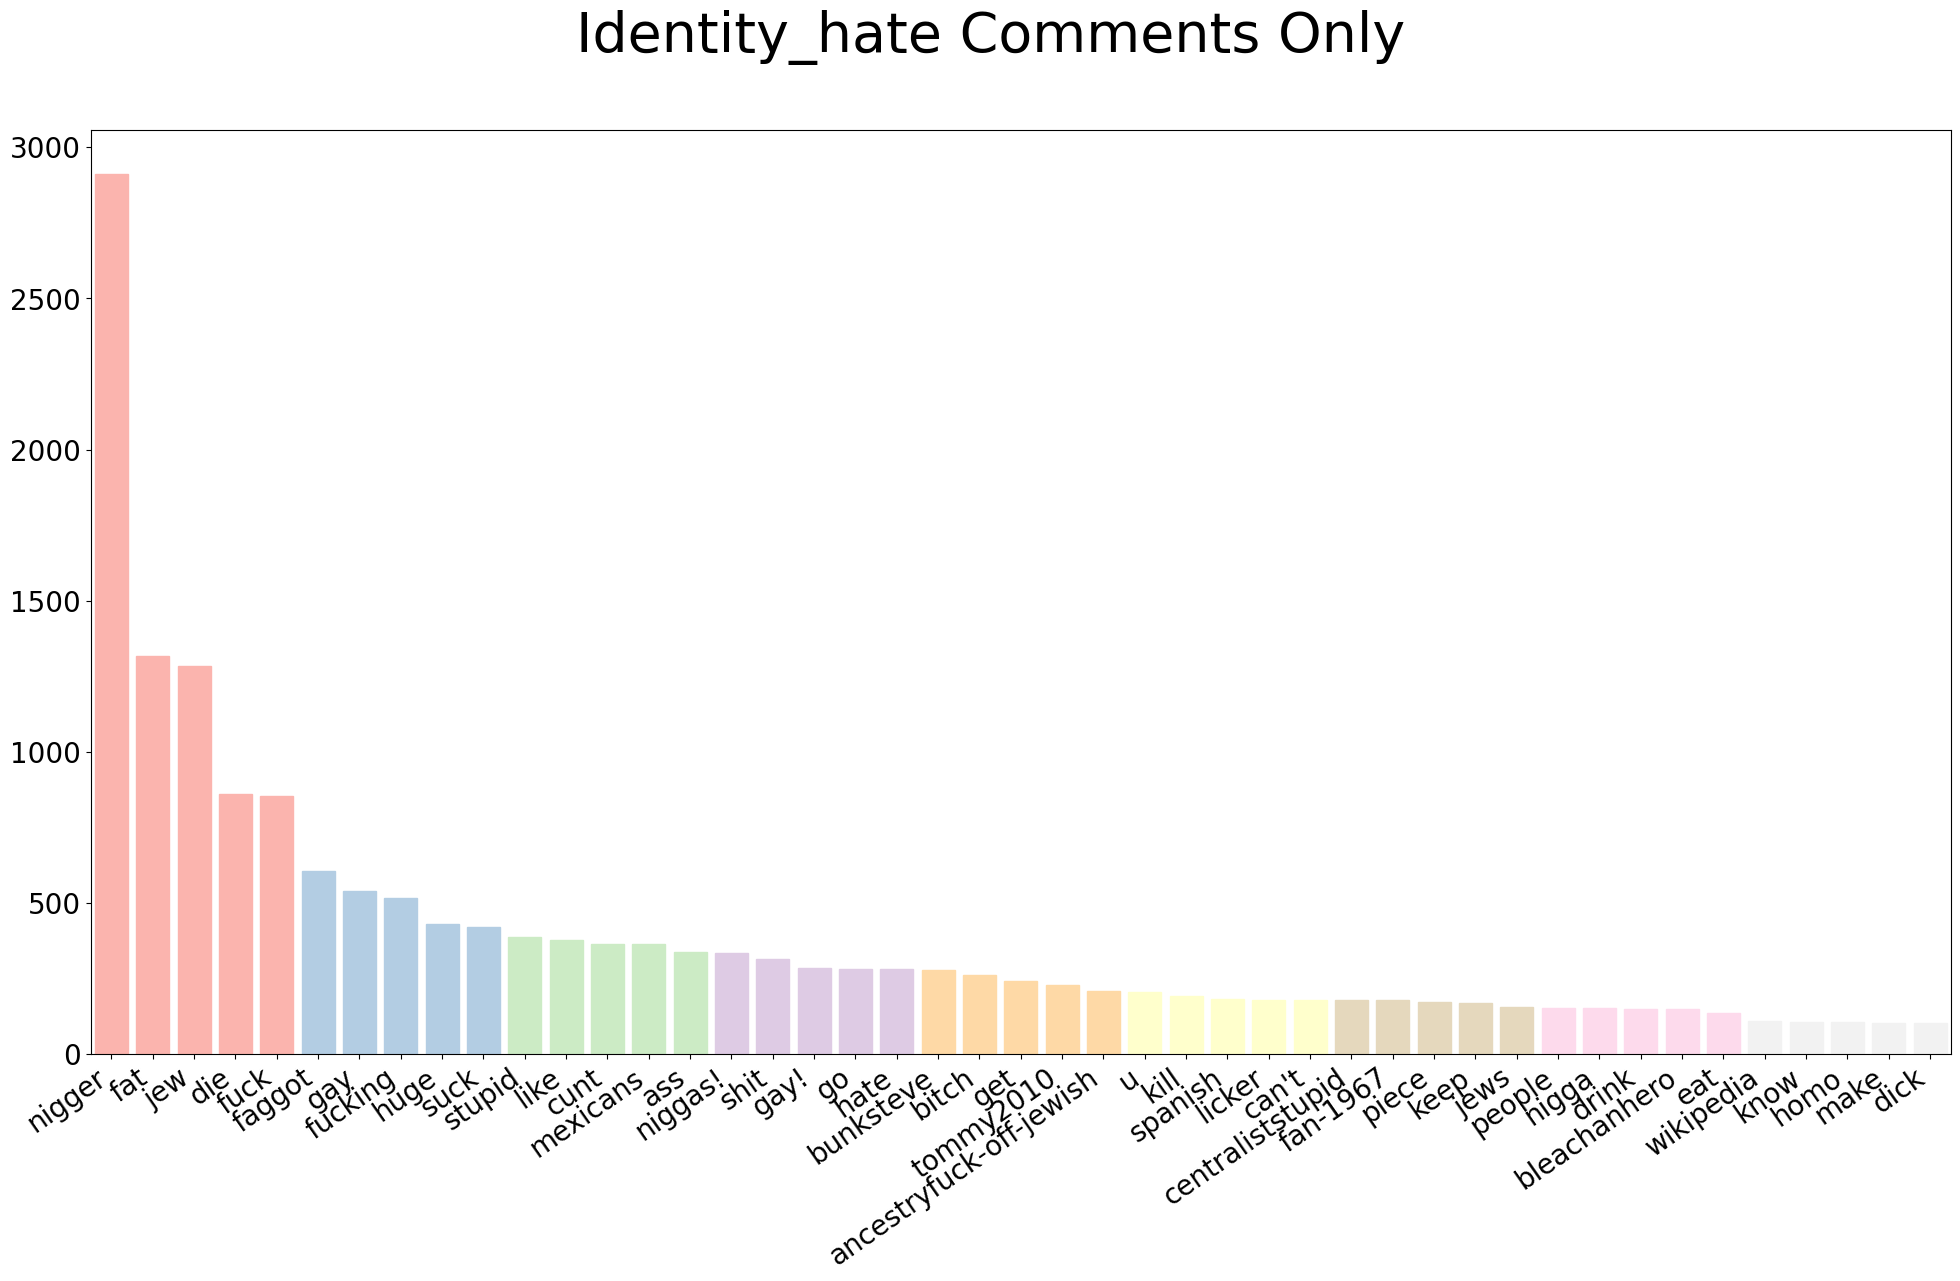

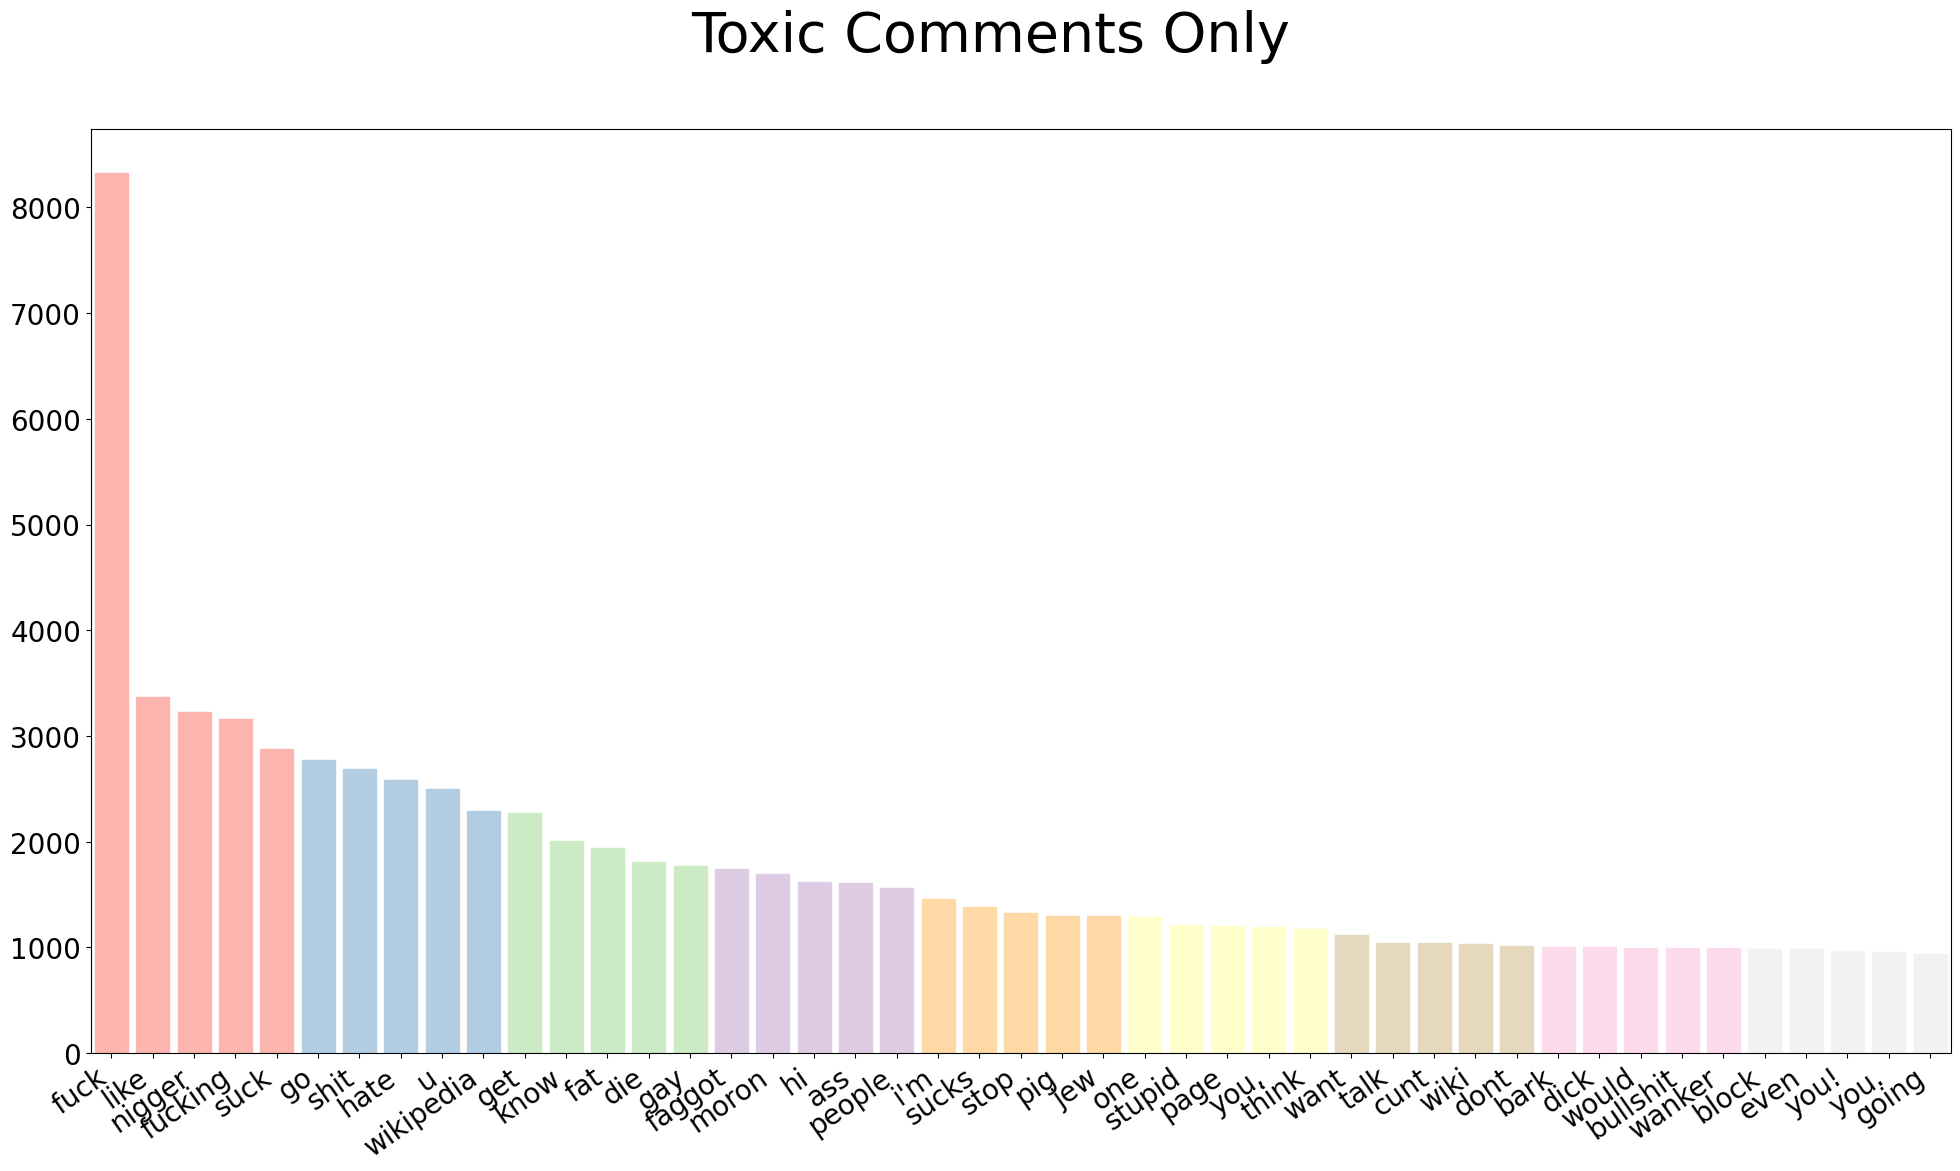

In [ ]:
# Define a tokenizer function
def tokenizer(text):
    return [token.lower() for token in text.split() if token.lower() not in string.punctuation]

# Get English stopwords
stopWords = set(stopwords.words('english'))

# Function to get word counts
def get_word_cnt(texts):
    # Tokenize and filter stopwords
    tokenized_texts = [tokenizer(text) for text in texts]
    filtered_texts = [[token for token in text if token not in stopWords] for text in tokenized_texts]

    # Count words
    word_cnt = Counter([token for sublist in filtered_texts for token in sublist])
    return word_cnt

# Function to plot word counts
def word_plot(word_cnt, num_words, title):
    plt.figure(figsize=(24, 12))
    plt.suptitle(title, fontsize=40)
    # Plotting without specifying palette
    ax = sns.barplot(x=[word[0] for word in word_cnt.most_common(num_words)],
                     y=[word[1] for word in word_cnt.most_common(num_words)])
    # Generate a list of colors
    colors = plt.cm.Pastel1(np.linspace(0, 1, num_words))
    # Apply the colors to each bar
    for i, bar in enumerate(ax.patches):
        bar.set_color(colors[i % len(colors)])
    plt.yticks(fontsize=20)
    plt.xticks(fontsize=20, rotation=35, ha='right')
    plt.show()

all_texts_clean = train_df[train_df['toxic'] == 0]['comment_text']
word_cnt_all_clean = get_word_cnt(all_texts_clean)
word_plot(word_cnt_all_clean, 45, 'Clean Comments Only')

targets = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
for label in targets:
    texts = train_df[train_df[label] == 1]['comment_text']
    word_cnt = get_word_cnt(texts)
    word_plot(word_cnt, 45, f'{label.capitalize()} Comments Only')

toxic_texts = train_df[train_df['toxic'] == 1]['comment_text']
word_cnt_toxic = get_word_cnt(toxic_texts)
word_plot(word_cnt_toxic, 45, 'Toxic Comments Only')

In [ ]:
# ! pip install wordcloud

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 511.1/511.1 kB 14.5 MB/s eta 0:00:0000:01


### Most frequent words in the dataset

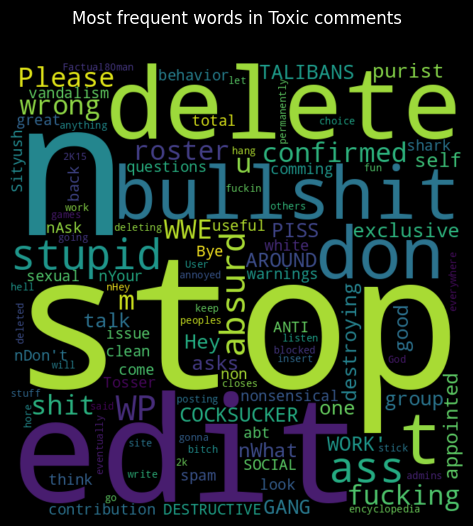

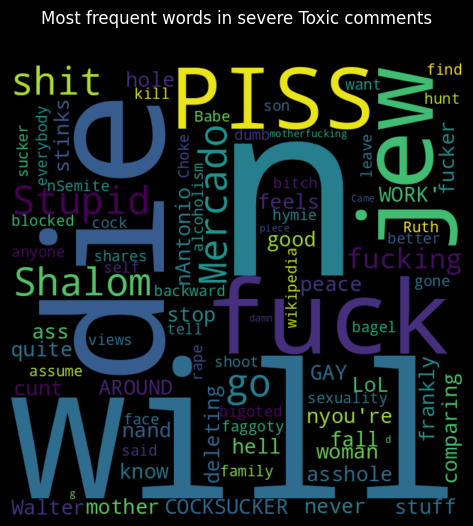

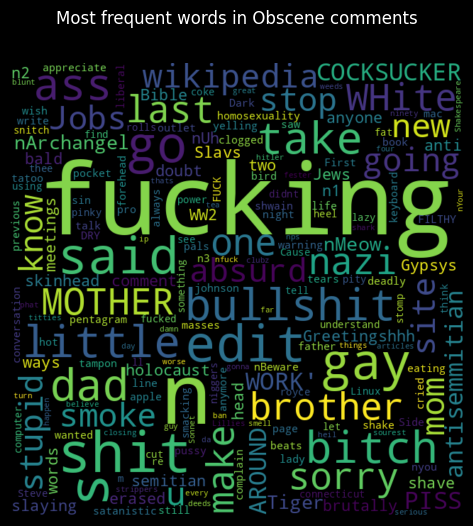

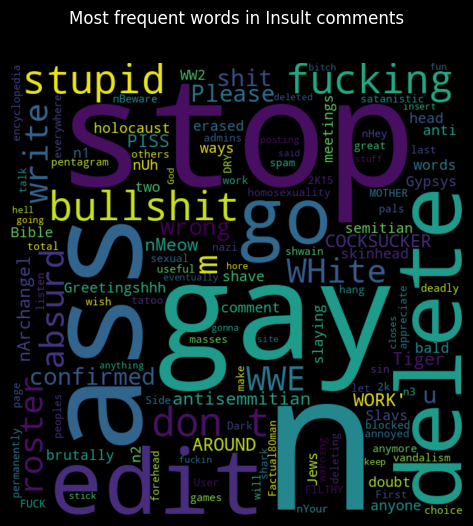

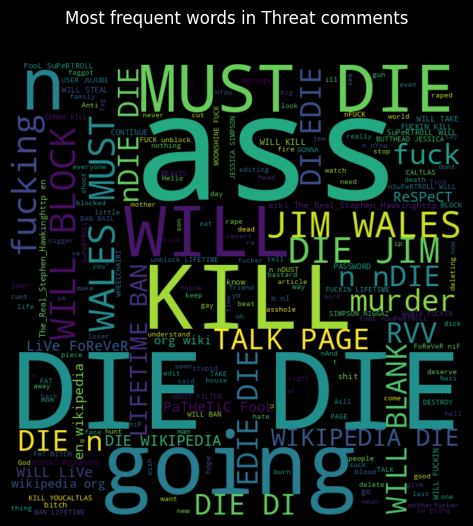

In [ ]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS

def word_plot(column,text):

    comments = train_df['comment_text'].loc[column == 1].values     # sort by toxicity

    word_cloud = WordCloud( width = 640, height = 640, background_color = 'black',
                stopwords = STOPWORDS).generate(str(comments))     # stopwords are a,an,the

    fig = plt.figure( figsize = (8, 5), facecolor = 'k', edgecolor = 'k')
    plt.subplot()
    plt.imshow(word_cloud, interpolation = 'bilinear')
    plt.suptitle("Most frequent words in " +  text , y = 1.06,color = "white")
    plt.tight_layout(pad = 0)
    plt.axis('off')
    plt.show()

word_plot(train_df['toxic'], "Toxic comments")
word_plot(train_df['severe_toxic'],"severe Toxic comments")
word_plot(train_df['obscene'],"Obscene comments")
word_plot(train_df['insult'],"Insult comments")
word_plot(train_df['threat'],"Threat comments")

### Label Distribution

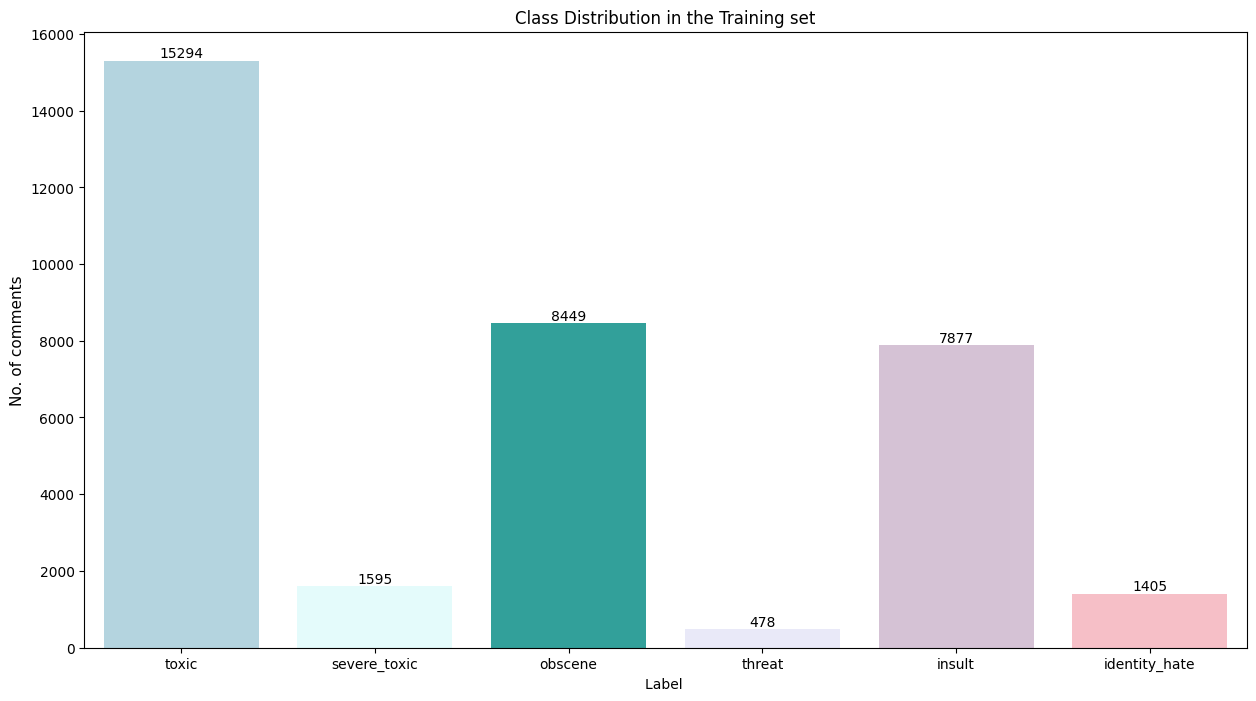

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Defining pastel colors using RGB values
pastel_colors = [
    (173, 216, 230),  # lightblue
    (224, 255, 255),  # lightcyan
    (32, 178, 170),   # lightseagreen
    (230, 230, 250),  # lavender
    (216, 191, 216),  # thistle
    (255, 182, 193)   # lightpink
]

# Normalizing RGB values to range [0, 1]
pastel_colors = [(r / 255, g / 255, b / 255) for (r, g, b) in pastel_colors]

# Creating palette with pastel colors
palette = sns.color_palette(pastel_colors)

x = train_df.iloc[:, 2:].sum()

plt.figure(figsize=(15, 8))
ax = sns.barplot(x=x.index, y=x.values, hue=x.index, palette=palette, legend=False)
plt.title("Class Distribution in the Training set")
plt.xlabel('Label ')
plt.ylabel('No. of comments', fontsize=11)

# Adding labels on the bars
patch = ax.patches
labels = x.values
for rect, label in zip(patch, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 10, label, va='bottom', ha='center')

plt.show()

### HeatMap

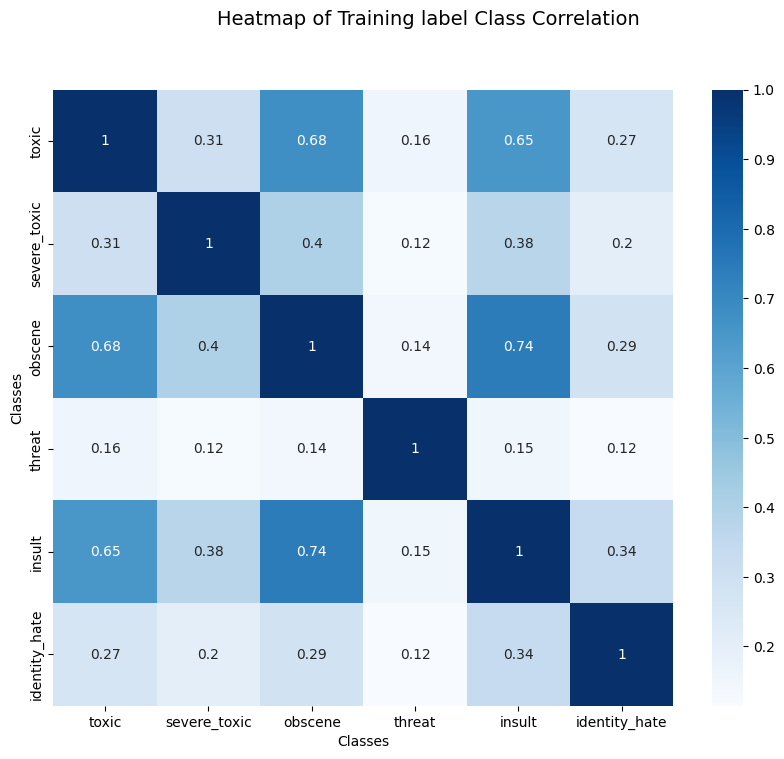

In [ ]:
fig = plt.figure(figsize=(10, 8))
sns.heatmap(train_df.corr(numeric_only=True), annot=True, cmap="Blues")
plt.suptitle('Heatmap of Training label Class Correlation', size=14)
plt.xlabel("Classes")
plt.ylabel("Classes")
plt.show()

### Preprocessing the Data

In [ ]:
X = train_df['comment_text']
y = train_df[train_df.columns[2:]].values

In [ ]:
X

0         Explanation\nWhy the edits made under my usern...
1         D'aww! He matches this background colour I'm s...
2         Hey man, I'm really not trying to edit war. It...
3         "\nMore\nI can't make any real suggestions on ...
4         You, sir, are my hero. Any chance you remember...
                                ...                        
159566    ":::::And for the second time of asking, when ...
159567    You should be ashamed of yourself \n\nThat is ...
159568    Spitzer \n\nUmm, theres no actual article for ...
159569    And it looks like it was actually you who put ...
159570    "\nAnd ... I really don't think you understand...
Name: comment_text, Length: 159571, dtype: object

In [ ]:
y

array([[0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       ...,
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0]])

In [ ]:
# ! pip install torchtext

### Tokenization, Lemmetization and Vocabulary Building

In [ ]:
import nltk
from nltk.stem import WordNetLemmatizer

# Download WordNet data
nltk.download('wordnet')

# Initialize WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

# Tokenize function with lemmatization
def tokenize(data, tokenizer, lemmatizer):
    tokenized_data = []
    for item in data:
        tokens = tokenizer(item)
        # Lemmatize tokens
        tokens = [lemmatizer.lemmatize(token) for token in tokens]
        tokenized_data.append(tokens)
    return tokenized_data

# Build vocab from iterator
def build_vocab(data, tokenizer, lemmatizer):
    tokenized_data = tokenize(data, tokenizer, lemmatizer)
    vocab = build_vocab_from_iterator(tokenized_data, specials=['<unk>', '<pad>'])
    vocab.set_default_index(vocab['<unk>'])
    return vocab

# Building vocabulary from the training set
vocab = build_vocab(train_df['comment_text'], tokenizer, lemmatizer)

[nltk_data] Downloading package wordnet to /root/nltk_data...


### Numericalization and Padding Sequences

In [ ]:
import torch

def numericalize(text, vocab, tokenizer, max_len):
    tokenized_text = tokenizer(text)
    numericalized_text = [vocab[token] for token in tokenized_text]
    # Pad or truncate the sequences to max_len
    if len(numericalized_text) > max_len:
        numericalized_text = numericalized_text[:max_len]
    else:
        numericalized_text += [vocab['<pad>']] * (max_len - len(numericalized_text))
    return numericalized_text

max_len = 300
embed_size=100
max_features=20000
vocabulary_size = 111591

# Apply the numericalization to the comment_text column
train_numericalized = [numericalize(text, vocab, tokenizer, max_len) for text in train_df['comment_text']]
test_numericalized = [numericalize(text, vocab, tokenizer, max_len) for text in test_df['comment_text']]

# Convert lists to tensors
train_tensor = torch.tensor(train_numericalized, dtype=torch.long)
test_tensor = torch.tensor(test_numericalized, dtype=torch.long)

In [ ]:
class CustomVectorizer:
    def __init__(self, tokenizer, max_features=243145, max_len=1800):
        self.tokenizer = tokenizer
        self.max_features = max_features
        self.max_len = max_len
        self.vocab = None

    def adapt(self, data):
        """Build vocabulary from the data"""
        tokenized_data = [self.tokenizer(item) for item in data]
        self.vocab = build_vocab_from_iterator(tokenized_data, specials=['<unk>', '<pad>'])
        self.vocab.set_default_index(self.vocab['<unk>'])

    def __call__(self, data):
        """Numericalize the data based on the vocabulary"""
        numericalized_data = [self.numericalize(text) for text in data]
        return torch.tensor(numericalized_data, dtype=torch.long)

    def numericalize(self, text):
        """Convert text to numericalized (vectorized) format"""
        tokenized_text = self.tokenizer(text)
        numericalized_text = [self.vocab[token] for token in tokenized_text]
        # Pad or truncate
        if len(numericalized_text) > self.max_len:
            numericalized_text = numericalized_text[:self.max_len]
        else:
            numericalized_text += [self.vocab['<pad>']] * (self.max_len - len(numericalized_text))
        return numericalized_text

In [ ]:
vectorizer = CustomVectorizer(tokenizer, max_features, max_len)
vectorizer.adapt(train_df['comment_text'].values)
train_vectorized = vectorizer(train_df['comment_text'].values)

# Print the shape of the vectorized data
print("Shape of vectorized train data:", train_vectorized.shape)

# Print the first few vectorized texts
print("First 5 vectorized text examples:")
for i in range(5):
    print(f"Text {i+1}:", train_vectorized[i])

Shape of vectorized train data: torch.Size([159571, 300])
First 5 vectorized text examples:
Text 1: tensor([  667,    85,     3,   140,   142,   185,    39,   663,  4900, 11398,
         1287,    96,   329,    27,    57,  2219,     9,    31, 11470,     4,
           61,  6856,    21,    71,  2785,   158,     6,  2932,    45,   130,
         1167, 16015,  2808,     2,     8,    55,    70,     9,    31,   253,
            3,   369,    41,     3,    50,    38,   155,     6,     9,    81,
         3505,    99,     2,  3118,     2,  4585,     2,  2375,     2,  1122,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,

### Data Pipeline

In [ ]:
from torch.utils.data import Dataset, DataLoader

class CommentsDataset(Dataset):
    def __init__(self, dataframe, vocab=None, max_len=1800):
        self.dataframe = dataframe
        self.tokenizer = get_tokenizer('basic_english')
        self.max_len = max_len
        if vocab is None:
            self.vocab = build_vocab_from_iterator(map(self.tokenizer, self.dataframe['comment_text']), specials=['<unk>'])
            self.vocab.set_default_index(self.vocab['<unk>'])
        else:
            self.vocab = vocab

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        text = self.dataframe.iloc[idx]['comment_text']
        encoded_text = [self.vocab[token] for token in self.tokenizer(text)][:self.max_len]
        encoded_text += [0] * (self.max_len - len(encoded_text)) # Padding
        label = self.dataframe.iloc[idx, 2:].values.astype(float)
        return torch.tensor(encoded_text, dtype=torch.long), torch.tensor(label, dtype=torch.float)

    def get_vocab(self):
        return self.vocab

In [ ]:
import pandas as pd
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

# Create a dataset instance to build vocab
temp_dataset = CommentsDataset(train_data)
max_features = len(temp_dataset.get_vocab())  # Get max_features from the vocab size

# DataLoaders
train_loader = DataLoader(CommentsDataset(train_data, vocab=temp_dataset.get_vocab()), batch_size=32, shuffle=True)
val_loader = DataLoader(CommentsDataset(validation_data, vocab=temp_dataset.get_vocab()), batch_size=32, shuffle=False)
test_loader = DataLoader(CommentsDataset(test_data, vocab=temp_dataset.get_vocab()), batch_size=32, shuffle=False)

In [ ]:
one_batch = next(iter(train_loader))

# Accessing the features and labels
features, labels = one_batch

print(features)  # Print the features of one batch
print(labels)    # Print the labels of one batch
print(f'Length of one batch: {len(features)}')

# Total number of batches
total_batches = len(train_loader)
print(f'The dataset contains {total_batches} batches')

tensor([[   9,  134,    4,  ...,    0,    0,    0],
        [  46, 7955,  519,  ...,    0,    0,    0],
        [   7,    9,    8,  ...,    0,    0,    0],
        ...,
        [ 476,   49,  178,  ...,    0,    0,    0],
        [   2,  522,  319,  ...,    0,    0,    0],
        [  13,  194,   18,  ...,    0,    0,    0]])
tensor([[0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0.],
        [1., 0., 1., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [1., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.,

### Modeling- Bidirectional Long Short-Term Memory layer (LSTM)

#### Building the Model

In [ ]:
import torch
import torch.nn as nn

class ToxicCommentModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim):
        super(ToxicCommentModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm1 = nn.LSTM(embedding_dim, hidden_dim, batch_first=True, bidirectional=True)
        self.lstm2 = nn.LSTM(hidden_dim * 2, hidden_dim, batch_first=True, bidirectional=True)
        self.fc1 = nn.Linear(hidden_dim * 2, 300)
        self.fc2 = nn.Linear(300, 30)
        self.output = nn.Linear(30, output_dim)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.embedding(x)  # x should now be [batch_size, seq_len, embedding_dim]
        x, _ = self.lstm1(x)
        x, _ = self.lstm2(x)
        x = x[:, -1, :]  # taking the output from the last LSTM cell
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.sigmoid(self.output(x))
        return x

# Simulate input preparation
vocab_size = 10000  # Assume a vocabulary size
embedding_dim = 100  # Size of each word embedding
hidden_dim = 128  # LSTM hidden dimensions
output_dim = 6  # Assuming 6 output classes
model = ToxicCommentModel(vocab_size, embedding_dim, hidden_dim, output_dim)

# Assume the vectorizer outputs an index tensor of shape [batch_size, seq_len]
input_indices = torch.randint(low=0, high=vocab_size, size=(1, 1800))
input_indices = input_indices.to("cuda")  # Assuming use of GPU

In [ ]:
vocab_size=243146

# Model instantiation
model = ToxicCommentModel(vocab_size, 30, 30, 6)
criterion = nn.BCELoss()
# Initialize the Adam optimizer with a learning rate of 0.001
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Printing the model will show its architecture
print(model)

ToxicCommentModel(
  (embedding): Embedding(243146, 30)
  (lstm1): LSTM(30, 30, batch_first=True, bidirectional=True)
  (lstm2): LSTM(60, 30, batch_first=True, bidirectional=True)
  (fc1): Linear(in_features=60, out_features=300, bias=True)
  (fc2): Linear(in_features=300, out_features=30, bias=True)
  (output): Linear(in_features=30, out_features=6, bias=True)
  (relu): ReLU()
  (sigmoid): Sigmoid()
)


In [ ]:
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
non_trainable_params = total_params - trainable_params

print(f"Total params: {total_params}")
print(f"Trainable params: {trainable_params}")
print(f"Non-trainable params: {non_trainable_params}")

Total params: 7358856
Trainable params: 7358856
Non-trainable params: 0


In [ ]:
# Check vocabulary size
print("Vocabulary size:", max_features + 1)

print(train_tensor.max())

Vocabulary size: 234867
tensor(243144)


### Training

In [ ]:
def train(model, train_loader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    total_correct = 0
    total_samples = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * inputs.size(0)
        predicted = torch.round(outputs)  # Threshold predictions at 0.5
        total_correct += (predicted == labels).float().sum().item()
        total_samples += labels.numel()

    average_loss = total_loss / total_samples
    accuracy = total_correct / total_samples
    return average_loss, accuracy

def validate(model, val_loader, criterion, device):
    model.eval()
    total_loss = 0
    total_correct = 0
    total_samples = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            total_loss += loss.item() * inputs.size(0)
            predicted = torch.round(outputs)  # Threshold predictions at 0.5
            total_correct += (predicted == labels).float().sum().item()
            total_samples += labels.numel()

    average_loss = total_loss / total_samples
    accuracy = total_correct / total_samples
    return average_loss, accuracy

# Training and Validation Execution
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
num_epochs = 2
for epoch in range(num_epochs):
    train_loss, train_accuracy = train(model, train_loader, optimizer, criterion, device)
    val_loss, val_accuracy = validate(model, val_loader, criterion, device)
    print(f'Epoch {epoch + 1}: Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}')

Epoch 1: Train Loss: 0.0241, Train Accuracy: 0.9631, Validation Loss: 0.0232, Validation Accuracy: 0.9640
Epoch 2: Train Loss: 0.0237, Train Accuracy: 0.9633, Validation Loss: 0.0234, Validation Accuracy: 0.9640


In [ ]:
import torch
import numpy as np
from sklearn.metrics import accuracy_score, roc_auc_score

def evaluate(model, test_loader, criterion, device):
    model.eval()  # Set the model to evaluation mode
    total_loss = 0
    total_correct = 0
    total_samples = 0
    all_probs = []
    all_labels = []
    with torch.no_grad():  # No gradients needed
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            total_loss += loss.item() * inputs.size(0)
            predicted = torch.round(outputs)
            total_correct += (predicted == labels).float().sum().item()
            total_samples += labels.numel()

            all_probs.extend(outputs.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    average_loss = total_loss / total_samples
    accuracy = total_correct / total_samples
    auc = roc_auc_score(all_labels, all_probs)

    return average_loss, accuracy, auc

# Assuming test_loader is defined and initialized
test_loss, test_accuracy, test_auc = evaluate(model, test_loader, criterion, device)
print('Test Loss: {:.4f}'.format(test_loss))
print('Test Accuracy: {:.4f}'.format(test_accuracy))
print('Test AUC: {:.4f}'.format(test_auc))

Test Loss: 0.0242
Test Accuracy: 0.9622
Test AUC: 0.5002


### Evaluation Metrics

In [ ]:
import torch
import numpy as np
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score

def evaluate(model, test_loader, criterion, device):
    model.eval()
    total_loss = 0
    total_samples = 0
    all_labels = []
    all_probs = []  # To store probability scores for AUC calculation
    all_predicted = []  # List to store all predicted labels

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            total_loss += loss.item() * inputs.size(0)
            total_samples += labels.numel()

            # Assuming model outputs logits, apply sigmoid to convert to probabilities
            probs = torch.sigmoid(outputs).cpu().numpy()
            predicted = torch.round(outputs).cpu().numpy()

            all_probs.extend(probs)
            all_labels.extend(labels.cpu().numpy())
            all_predicted.extend(predicted)

    average_loss = total_loss / total_samples
    all_probs = np.array(all_probs).flatten()
    all_labels = np.array(all_labels).flatten()
    all_predicted = np.array(all_predicted).flatten()

    # Calculate AUC
    auc = roc_auc_score(all_labels, all_probs)

    # Calculate Accuracy using sklearn for consistency with AUC calculation
    accuracy = accuracy_score(all_labels, all_predicted)

    # Calculate other metrics
    precision = precision_score(all_labels, all_predicted)
    recall = recall_score(all_labels, all_predicted)

    return average_loss, accuracy, auc, precision, recall

# Evaluate function
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
test_loss, test_accuracy, test_auc, test_precision, test_recall = evaluate(model, test_loader, criterion, device)

# Print all evaluation metrics
print('Average Loss: {:.4f}'.format(test_loss))
print('Accuracy: {:.4f}'.format(test_accuracy))
print('AUC: {:.4f}'.format(test_auc))

Average Loss: 0.0242
Accuracy: 0.9622
AUC: 0.7515


#### Make Predictions

In [ ]:
import torch

# List of sentences to predict
sentences = [
    "You freaking suck! I am going to hit you.",
    "You're such an idiot.",
    "I'll kill you if I see you again."
]

# Preprocess function for multiple sentences
def preprocess_multiple_inputs(sentences, vocab, tokenizer, max_len):
    # Numericalize each sentence and pad/truncate to max_len
    input_numericalized = [numericalize(sentence, vocab, tokenizer, max_len) for sentence in sentences]
    input_padded = [seq[:max_len] + [0] * max(0, max_len - len(seq)) for seq in input_numericalized]
    return torch.tensor(input_padded, dtype=torch.long)

# Preprocess the list of sentences
input_tensor = preprocess_multiple_inputs(sentences, vocab, tokenizer, max_len)

# Move the input tensor to the CPU
input_tensor_cpu = input_tensor.cpu()

# Move the model to the CPU
model_cpu = model.cpu()

# Make predictions
model_cpu.eval()  # Set the model to evaluation mode
with torch.no_grad():
    y_pred = model_cpu(input_tensor_cpu)
    probabilities = torch.sigmoid(y_pred)
    y_pred_np = probabilities.numpy()

# Display the predictions for each input text
print("Predictions for each sentence:")
for i, sentence in enumerate(sentences):
    print(f"Sentence: {sentence}")
    print(f"Probabilities: {y_pred_np[i]}")
    print()  # Newline for clarity

Predictions for each sentence:
Sentence: You freaking suck! I am going to hit you.
Probabilities: [0.6272215  0.6295797  0.62130356 0.6225612  0.61370176 0.6222102 ]

Sentence: You're such an idiot.
Probabilities: [0.6272786 0.6297574 0.6214662 0.6225908 0.6137156 0.6223276]

Sentence: I'll kill you if I see you again.
Probabilities: [0.6273136  0.6298106  0.62152016 0.62263334 0.613665   0.62240744]



#### Save the Model

In [ ]:
torch.save(model.state_dict(), 'toxic_comment_model.pth')

# Assume 'vocab' is a vocabulary object from torchtext or similar; save it using pickle
import pickle
with open('vocab.pkl', 'wb') as f:
    pickle.dump(vocab, f)

In [ ]:
import torch
import numpy as np
import pandas as pd

# List of output classes
list_classes = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

# Moving the model to the CPU for inference
model_cpu = model.cpu()
model_cpu.eval()

# Making predictions on all the test labels
with torch.no_grad():
    y_pred = model_cpu(input_tensor_cpu)
    probabilities = torch.sigmoid(y_pred)
    y_pred_np = probabilities.numpy()

# Loading the sample submission file
sample_submission_path = "/content/drive/MyDrive/jigsaw-toxic-comment-classification-challenge/sample_submission.csv.zip"
sample_submission = pd.read_csv(sample_submission_path)

# Update the filtered submission DataFrame with the predicted probabilities
sample_submission[list_classes] = y_pred_np

# Save the updated DataFrame to a CSV file for submission
output_file = "Submission.csv"
sample_submission.to_csv(output_file, index=False)

print(f"Submission file '{output_file}' created successfully.")

Submission file 'Submission.csv' created successfully.


Probabilities close to 1 indicate high confidence that the comment belongs to that category.
Probabilities close to 0 suggest a low likelihood of the comment being classified in that category.